In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
import seaborn as sns
import shutil

2024-05-23 12:43:25.867794: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 12:43:25.887622: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-23 12:43:25.888153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 12:43:26.257970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import re
# Read in the images data
images = pd.read_csv('../datasets/images_dataset_clean4.csv')

# Read in the reports data 
reports = pd.read_csv('../datasets/report_dataset_clean4.csv')

# Merge the images and reports data on the ID column
df = pd.merge(images, reports, on='id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3012 entries, 0 to 3011
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3012 non-null   int64  
 1   filename        3012 non-null   object 
 2   image_path      3012 non-null   object 
 3   report_file     3012 non-null   object 
 4   body_part       3012 non-null   object 
 5   content         3012 non-null   object 
 6   conclusion      3012 non-null   object 
 7   disease_status  3012 non-null   int64  
 8   disease_type    1721 non-null   object 
 9   location        0 non-null      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 235.4+ KB


In [3]:
df.head(5)

,id,filename,image_path,report_file,body_part,content,conclusion,disease_status,disease_type,location
0,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abdomen,preperitoneal fat dan otot psoas line simetris...,tidak tampak kelainan radiologik.,0,NaN,NaN
1,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abdomen,preperitoneal fat dan otot psoas line simetris...,tidak tampak kelainan radiologik.,0,NaN,NaN
2,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abdomen,preperitoneal fat dan otot psoas line simetris...,tidak tampak kelainan radiologik.,0,NaN,NaN
3,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abdomen,preperitoneal fat dan otot psoas line simetris...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN
4,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abdomen,preperitoneal fat dan otot psoas line simetris...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN


In [4]:
print(df.groupby('body_part').size())

body_part
abdomen                   277
ankle                     102
antebrachii                85
bahu                       79
cruris                    114
cubiti                     43
femur                     111
genu                      343
hip_joint                  75
humerus                    86
kepala                     56
manus                     102
os_sacro_coccygeus         29
pedis                     157
pelvis                     81
thorax                    406
vertebra_cervical         186
vertebra_lumbosakral      470
vertebra_thoracolumbal    104
wrist                     106
dtype: int64


In [5]:
# Loop through each body part
for body_part in df['body_part'].unique():
    for status in [0, 1]:
        count = df[(df['body_part'] == body_part) & (df['disease_status'] == status)].shape[0]
        # print(f"Count for body part '{body_part}' with status {status}: {count}")
        
        # Print body part and status if count is 0
        if count == 0:
            print(f"Body part '{body_part}' with status {status} has count 0.")

disease_status
1    1721
0    1291
Name: count, dtype: int64


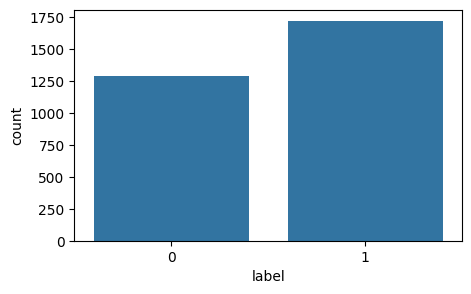

In [6]:
print(df['disease_status'].value_counts())

plt.figure(figsize=(5, 3)) 
sns.countplot(x='disease_status', data=df)
plt.xlabel('label')
plt.ylabel('count')

plt.show()

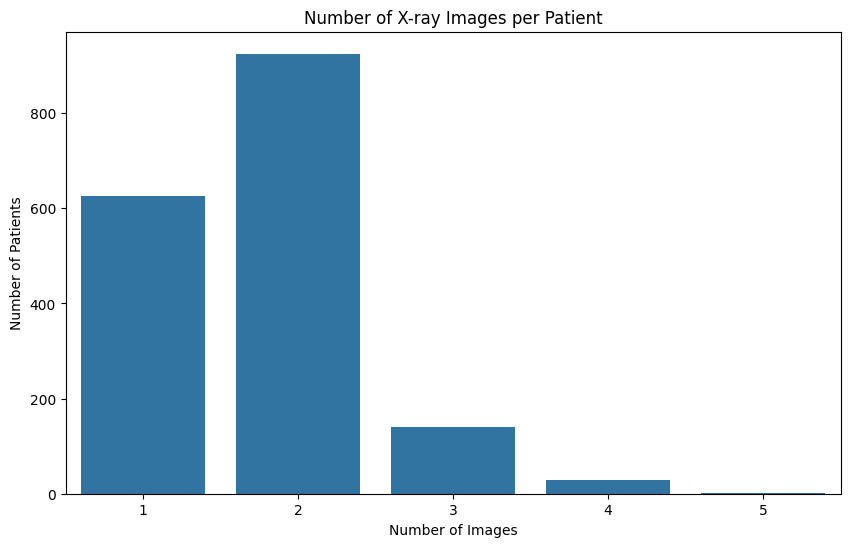

In [7]:
# Count the number of images per patient
images_per_patient = df['id'].value_counts()

# Convert from Series to Dataframe
images_per_patient_df = images_per_patient.reset_index()

# Specify columns
images_per_patient_df.columns = ['patient_id', 'image_count']

# Plot the distribution of images per patient using countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='image_count', data=images_per_patient_df)
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.title('Number of X-ray Images per Patient')
plt.show()

In [8]:
def show_image_normal(loc):
    img = cv2.imread(df['image_path'].loc[loc])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.imshow(img)
    plt.title(df['image_path'].loc[loc], fontsize=9)
    plt.show()
    print(f"Image path: {df['image_path'].loc[loc]}")

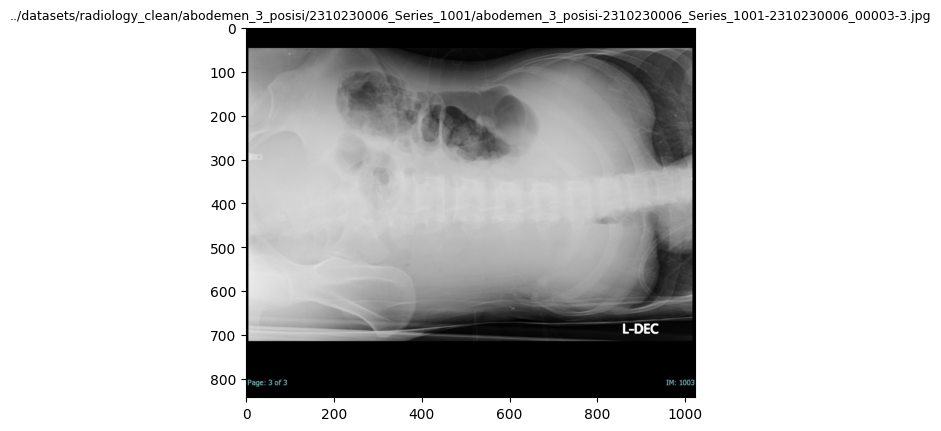

Image path: ../datasets/radiology_clean/abodemen_3_posisi/2310230006_Series_1001/abodemen_3_posisi-2310230006_Series_1001-2310230006_00003-3.jpg


In [9]:
show_image_normal(11)

In [10]:
import itertools

# list to hold new df rows
new_rows = []

# iterate over each unique patient
for patient_id in df['id'].unique():
    # get all images for the patient
    patient_images = df[df['id'] == patient_id]

    # check if the patient has only one image
    if len(patient_images) == 1:
        # duplicate the single image
        img = patient_images['image_path'].iloc[0]
        new_row = patient_images.iloc[0].copy()
        new_row['img_1'] = img
        new_row['img_2'] = img
        new_rows.append(new_row)
    else:
        # create combinations (unique pairs) of images for the patient
        image_pairs = list(itertools.combinations(patient_images['image_path'], 2))
        
        for img1, img2 in image_pairs:
            new_row = patient_images.iloc[0].copy()  # copy data from the first row of the patient (retain all the data)
            new_row['img_1'] = img1 # add img_1 column
            new_row['img_2'] = img2 # add img_2 column
            new_rows.append(new_row)

# Final dataframe
df = pd.DataFrame(new_rows)

df

,id,filename,image_path,report_file,body_part,content,conclusion,disease_status,disease_type,location,img_1,img_2
0,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abdomen,preperitoneal fat dan otot psoas line simetris...,tidak tampak kelainan radiologik.,0,NaN,NaN,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
0,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abdomen,preperitoneal fat dan otot psoas line simetris...,tidak tampak kelainan radiologik.,0,NaN,NaN,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
0,1,abodemen_3_posisi-2310200157_Series_1001-23102...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310200157_Series_1001-23102...,abdomen,preperitoneal fat dan otot psoas line simetris...,tidak tampak kelainan radiologik.,0,NaN,NaN,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
3,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abdomen,preperitoneal fat dan otot psoas line simetris...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
3,2,abodemen_3_posisi-2310220005_00001-2310220005_...,../datasets/radiology_clean/abodemen_3_posisi/...,abodemen_3_posisi-2310220005_00001-report-1.txt,abdomen,preperitoneal fat dan otot psoas line simetris...,dilatasi ringan usus pada regio abdomen kanan ...,1,dilatasi ringan usus pada regio abdomen kanan ...,NaN,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
...,...,...,...,...,...,...,...,...,...,...,...,...
3005,1715,wrist_joint_sinistra-2401190046_Series_1001-24...,../datasets/radiology_clean/wrist_joint_sinist...,wrist_joint_sinistra-2401190046_Series_1001-re...,wrist,tampak internal fiksasi terpasang baik pada di...,tampak internal fiksasi terpasang baik pada di...,1,tampak internal fiksasi terpasang baik pada di...,NaN,../datasets/radiology_clean/wrist_joint_sinist...,../datasets/radiology_clean/wrist_joint_sinist...
3007,1716,wrist_joint_sinistra-2402180054_Series_1001-24...,../datasets/radiology_clean/wrist_joint_sinist...,wrist_joint_sinistra-2402180054_Series_1001-re...,wrist,kedudukan tulang tampak baik. tak tampak frakt...,tak tampak kelainan radiologik.,0,NaN,NaN,../datasets/radiology_clean/wrist_joint_sinist...,../datasets/radiology_clean/wrist_joint_sinist...
3009,1717,wrist_joint_sinistra-3-3.jpg,../datasets/radiology_clean/wrist_joint_sinist...,wrist_joint_sinistra-3-3-report-1.txt,wrist,kedudukan tulang tampak berubah. tampak fraktu...,fraktur distal radius ulna kiri. penerunan den...,1,fraktur distal radius ulna kiri. penerunan den...,NaN,../datasets/radiology_clean/wrist_joint_sinist...,../datasets/radiology_clean/wrist_joint_sinist...
3010,1718,wrist_joint_sinistra-4-4.jpg,../datasets/radiology_clean/wrist_joint_sinist...,wrist_joint_sinistra-4-4-report-1.txt,wrist,besar bentuk dan struktur trabekula tulang rad...,osteoarthritis pergelangan tangan sendi kiri.,1,osteoarthritis pergelangan tangan sendi kiri.,NaN,../datasets/radiology_clean/wrist_joint_sinist...,../datasets/radiology_clean/wrist_joint_sinist...


disease_status
1    1255
0     893
Name: count, dtype: int64


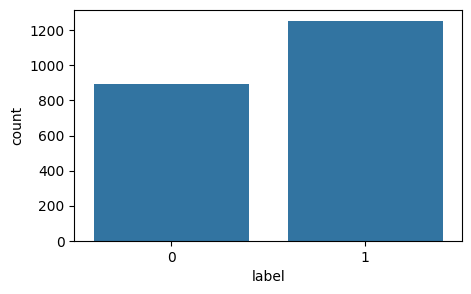

In [11]:
print(df['disease_status'].value_counts())

plt.figure(figsize=(5, 3)) 
sns.countplot(x='disease_status', data=df)
plt.xlabel('label')
plt.ylabel('count')

plt.show()

In [12]:
# import os
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

# # Function to save augmented images and return the new file path
# def save_augmented_image(image, original_filename, directory='combination_augmented_images'):

#     # Generate a new filename based on the original filename
#     # filename_without_extension, extension = os.path.splitext(original_filename)
#     # new_filename = f"{filename_without_extension}_aug{uuid.uuid4()}{extension}"
#     filepath = os.path.join('..', 'datasets', directory, original_filename)

#     # Save the image to disk
#     save_img(filepath, image)
#     return filepath

# # Instantiate the ImageDataGenerator with desired augmentations
# datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )


# # filtered_df = df[~df['body_part'].isin(['thorax', 'vertebra_lumbosakral'])]
# augmented_rows = []

# # check augmented image dir
# directory_path = os.path.join('..', 'datasets', 'combination_augmented_images')
# if os.path.exists(directory_path):
#     shutil.rmtree(directory_path)
# os.mkdir(directory_path)

# # Process each image pair
# for index, row in df.iterrows():
#     # Load and augment the first image
#     img_path_1 = row['img_1']
#     img_1 = load_img(img_path_1)  # This should be the full path
#     img_1 = img_to_array(img_1)
#     img_1 = datagen.random_transform(img_1)

#     # Load and augment the second image
#     img_path_2 = row['img_2']
#     img_2 = load_img(img_path_2)  # This should be the full path
#     img_2 = img_to_array(img_2)
#     img_2 = datagen.random_transform(img_2)

#     # Save the augmented images
#     new_img_path_1 = save_augmented_image(img_1, os.path.basename(img_path_1))
#     new_img_path_2 = save_augmented_image(img_2, os.path.basename(img_path_2))

#     # Append new row with the augmented images
#     new_row = row.copy()
#     new_row['img_1'] = new_img_path_1
#     new_row['img_2'] = new_img_path_2
#     augmented_rows.append(new_row)

# # Create a new DataFrame with the augmented rows
# augmented_df = pd.DataFrame(augmented_rows)

# # Concatenate the new DataFrame with the original one
# df = pd.concat([df, augmented_df], ignore_index=True)

# df

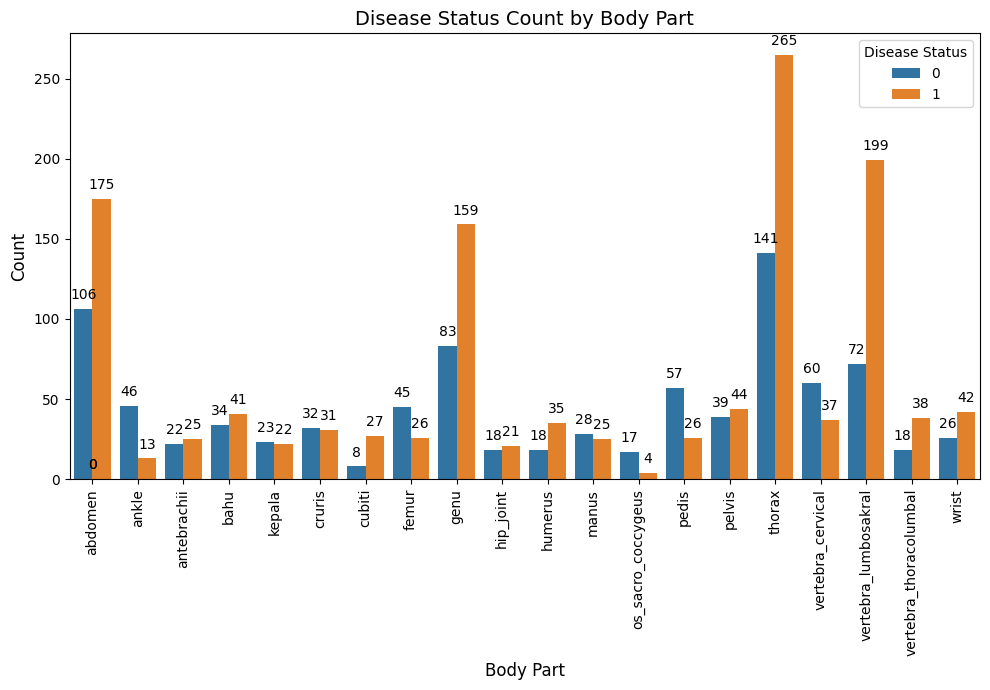

In [13]:
plot_df = df.copy()
plot_df['body_part'] = plot_df['body_part'].astype(str)
plot_df['disease_status'] = plot_df['disease_status'].astype(str)

plt.figure(figsize=(10, 7))  # Increase the figure size for better readability
ax = sns.countplot(x='body_part', hue='disease_status', data=plot_df)
plt.xlabel('Body Part', fontsize=12)  # You can adjust the font size as needed
plt.ylabel('Count', fontsize=12)  # You can adjust the font size as needed
plt.title('Disease Status Count by Body Part', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Add count annotations to each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.legend(title='Disease Status')
plt.tight_layout()
plt.show()

In [14]:
# body_parts_to_adjust = ['thorax', 'vertebra_lumbosakral']

# for body_part in body_parts_to_adjust:
#     # count the normal data
#     normal_count = len(df[(df['body_part'] == body_part) & (df['disease_status'] == 0)])
    
#     # target number of abnormal data: normal data count + 100
#     target_abnormal_count = normal_count + 100
    
#     # abnormal data for the body part
#     abnormal_data = df[(df['body_part'] == body_part) & (df['disease_status'] == 1)]
    
#     # check if there are more abnormal data than the target count
#     if len(abnormal_data) > target_abnormal_count:
#         # number of data to drop
#         drop_count = len(abnormal_data) - target_abnormal_count
        
#         # random select indices od abnormal data to drop
#         indices_to_drop = np.random.choice(abnormal_data.index, size=drop_count, replace=False)
        
#         # drop the selected indices from the df
#         df = df.drop(indices_to_drop)

In [15]:
# # Visualize
# plt.figure(figsize=(10, 6))  # Increase the figure size for better readability
# ax = sns.countplot(x='body_part', hue='disease_status', data=df)
# plt.xlabel('Body Part', fontsize=12)  # You can adjust the font size as needed
# plt.ylabel('Count', fontsize=12)  # You can adjust the font size as needed
# plt.title('Disease Status Count by Body Part', fontsize=14)
# plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# # Annotating the bars with the count values
# for bar in ax.patches:
#     height = bar.get_height()
#     # Adding annotations on top of each bar
#     ax.annotate(f'{int(height)}',
#                 xy=(bar.get_x() + bar.get_width() / 2., height),
#                 xytext=(0, 5),  # 3 points vertical offset
#                 textcoords="offset points",
#                 ha='center',
#                 va='center',
#                 fontsize=9)
    
# plt.legend(title='Disease Status', labels=['0', '1'])
# plt.tight_layout()  # Adjust the layout
# plt.show()

In [16]:
print(f"Number of classes in body part: {df['body_part'].nunique()}")

Number of classes in body part: 20


In [17]:
df.drop(columns=["filename", "report_file", "content", "conclusion", "disease_type", "location", "image_path"], inplace=True)
df = df.rename(columns={'id': 'patient_id'})

df.head(5)

,patient_id,body_part,disease_status,img_1,img_2
0,1,abdomen,0,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
0,1,abdomen,0,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
0,1,abdomen,0,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
3,2,abdomen,1,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
3,2,abdomen,1,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...


disease_status
1    1255
0     893
Name: count, dtype: int64


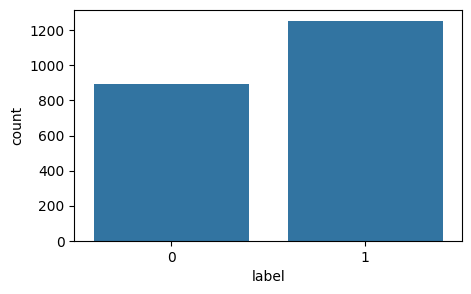

In [18]:
print(df['disease_status'].value_counts())

plt.figure(figsize=(5, 3)) 
sns.countplot(x='disease_status', data=df)
plt.xlabel('label')
plt.ylabel('count')

plt.show()

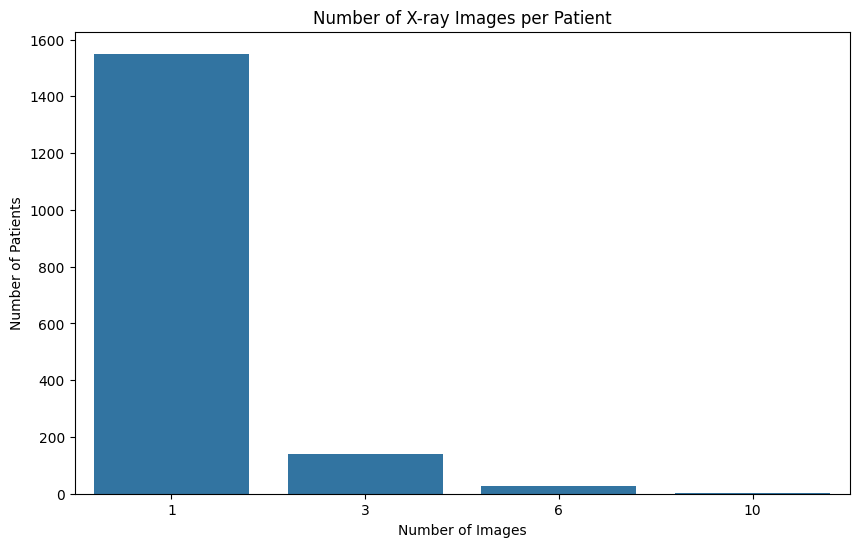

In [19]:
# Count the number of images per patient
images_per_patient = df['patient_id'].value_counts()

# Convert from Series to Dataframe
images_per_patient_df = images_per_patient.reset_index()

# Specify columns
images_per_patient_df.columns = ['patient_id', 'image_count']

# Plot the distribution of images per patient using countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='image_count', data=images_per_patient_df)
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.title('Number of X-ray Images per Patient')
plt.show()

In [20]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Reshape, Flatten, BatchNormalization
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras import backend as K
import numpy as np
import os
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3)
)

# freeze all the layers
for layer in base_model.layers:
    layer.trainable = False
 
base_model.summary()

2024-05-23 12:43:28.723020: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-23 12:43:28.723036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: csbui
2024-05-23 12:43:28.723039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: csbui
2024-05-23 12:43:28.723100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.54.14
2024-05-23 12:43:28.723111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  550.54.14  Release Build  (dvs-builder@U16-A24-2-2)  Thu Feb 22 01:44:50 UTC 2024
GCC version:  gcc version 12.3.0 (Ubuntu 12.3.0-1ubuntu1~22.04

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [21]:
input_tensor1 = Input(shape=(224, 224, 3), name="input_layer1")
input_tensor2 = Input(shape=(224, 224, 3), name="input_layer2")

x1 = base_model(input_tensor1, training=False)  # training=False to avoid updating batch norm statistics
x2 = base_model(input_tensor2, training=False)  # training=False to avoid updating batch norm statistics

x1 = Conv2D(32, (1, 1), activation='relu', padding='same')(x1)
x2 = Conv2D(32, (1, 1), activation='relu', padding='same')(x2)

x1 = Conv2D(32, (1, 1), activation='relu', padding='same')(x1)
x2 = Conv2D(32, (1, 1), activation='relu', padding='same')(x2)

x1 = Conv2D(32, (1, 1), activation='relu', padding='same')(x1)
x2 = Conv2D(32, (1, 1), activation='relu', padding='same')(x2)

x1 = Dropout(0.3)(x1)
x2 = Dropout(0.3)(x2)

x1 = GlobalAveragePooling2D()(x1)
x2 = GlobalAveragePooling2D()(x2)

concatenated = Concatenate()([x1, x2])

x = Dense(8, activation='relu')(concatenated)  
x = Dropout(0.4)(x) 

# x = Dense(16, activation='relu')(x)  
# x = Dropout(0.4)(x) 

# Hidden dense layer for binary classification
hidden_binary = Dense(units=16, activation='relu')(x)

# binary classification 
binary_output = Dense(1, activation='sigmoid', name='binary_output')(hidden_binary)

# model with two output layers: binary & multiclass classification
model = Model(inputs=[input_tensor1, input_tensor2], outputs=binary_output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer1 (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_layer2 (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_layer1[0][0]',        
 tional)                                                             'input_layer2[0][0]']        
                                                                                                  
 conv2d (Conv2D)             (None, 7, 7, 32)             40992     ['mobilenetv2_1.00_224[0][

In [22]:
BUFFER_SIZE = 3000
BATCH_SIZE = 128

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


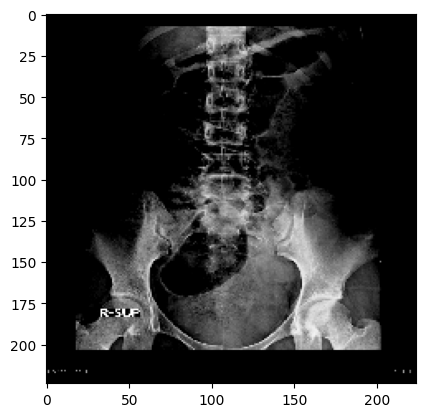

In [23]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img_path):

    # Load a grayscale image
    img = load_img(img_path, color_mode='grayscale', target_size=(224, 224))
    
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Replicate the grayscale channel three times to create a pseudo-RGB image
    pseudo_rgb_img = np.repeat(img_array, 3, axis=2)
    
    # Preprocess the input image for VGG19
    processed_img = preprocess_input(pseudo_rgb_img)

    return processed_img

def preprocess_xray_image(img_path, target_size=(224, 224)):
    # Load the image in grayscale mode
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image to the target size
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    
    # Apply adaptive masking if necessary
    # Assuming we use adaptive thresholding as a form of masking
    # You may adjust the parameters based on your needs
    mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, blockSize=11, C=2)
    img = cv2.bitwise_and(img, img, mask=mask)

    # Apply histogram equalization
    img = cv2.equalizeHist(img)
    
    # Apply Gaussian blur
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # Convert the image to RGB (3-channel)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Normalize the image - scale pixel values to the range [0, 1]
    img = img_rgb / 255.0
    
    return img

img = preprocess_image('../datasets/radiology_clean/abodemen_3_posisi/2310240157_Series_1001/abodemen_3_posisi-2310240157_Series_1001-2310240157_00001-1.jpg')  # Convert from BGR to RGB
plt.imshow(img, cmap='grey')
plt.show()

# print(img.shape)

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from sklearn.utils import resample

def preprocess_data(data):
    X_pairs = []
    y = []

    for _, row in data.iterrows():
        img_path1 = row['img_1']
        img_path2 = row['img_2']
        disease_label = row['disease_status']
        
        img1 = preprocess_image(img_path1)
        img2 = preprocess_image(img_path2)

        X_pairs.append((img1, img2))  # Add the pair of images as a tuple
        y.append(disease_label)

    # Convert lists to numpy arrays
    X_pairs = np.array(X_pairs)
    y = np.array(y)
    
    return X_pairs, y

In [25]:
body_parts_to_keep = ['thorax', 'abdomen', 'vertebra_lumbosakral', 'genu']

# Filter the dataframe
df = df[df['body_part'].isin(body_parts_to_keep)]

unique_patient_ids = df['patient_id'].unique()
unique_patient_ids.sort()

# Create a new ID for each unique patient ID
new_patient_id_map = {old_id: new_id + 1 for new_id, old_id in enumerate(unique_patient_ids)}

# Map the old patient IDs in the dataframe to the new IDs
df['patient_id'] = df['patient_id'].map(new_patient_id_map)

pd.set_option('display.max_rows', None)
df

,patient_id,body_part,disease_status,img_1,img_2
0,1,abdomen,0,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
0,1,abdomen,0,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
0,1,abdomen,0,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
3,2,abdomen,1,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
3,2,abdomen,1,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
3,2,abdomen,1,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
6,3,abdomen,1,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
6,3,abdomen,1,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
6,3,abdomen,1,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...
9,4,abdomen,1,../datasets/radiology_clean/abodemen_3_posisi/...,../datasets/radiology_clean/abodemen_3_posisi/...


In [26]:
from sklearn.model_selection import GroupShuffleSplit

df_train_val, df_test = train_test_split(df, test_size=0.2, stratify=df['disease_status'], random_state=42)

# df_majority = df_train_val[(df_train_val['disease_status'] == 1)]
# df_minority = df_train_val[(df_train_val['disease_status'] == 0)]

# df_minority_oversampled = resample(df_minority, 
#                                    replace=True,     # Sample with replacement
#                                    n_samples=len(df_minority) + 700,    # Match number in majority class
#                                    random_state=123) # Reproducible results

# df_majority_oversampled = resample(df_majority, 
#                                    replace=True,     # Sample with replacement
#                                    n_samples=len(df_majority) + 500,    # Match number in majority class
#                                    random_state=123) # Reproducible results

# df_oversampled = pd.concat([df_majority_oversampled, df_minority_oversampled])

# df_train_val = df_oversampled.sample(frac=1, random_state=123).reset_index(drop=True)

disease_status
1    638
0    322
Name: count, dtype: int64


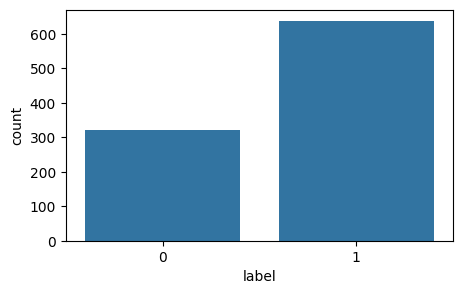

body_part
abdomen                 227
genu                    200
thorax                  323
vertebra_lumbosakral    210
dtype: int64
212 111


In [27]:
print(df_train_val['disease_status'].value_counts())

plt.figure(figsize=(5, 3)) 
sns.countplot(x='disease_status', data=df_train_val)
plt.xlabel('label')
plt.ylabel('count')

plt.show()

print(df_train_val.groupby('body_part').size())

count_thorax_disease_1 = len(df_train_val[(df_train_val['body_part'] == 'thorax') & (df_train_val['disease_status'] == 1)])
count_thorax_normal_1 = len(df_train_val[(df_train_val['body_part'] == 'thorax') & (df_train_val['disease_status'] == 0)])

print(count_thorax_disease_1, count_thorax_normal_1)

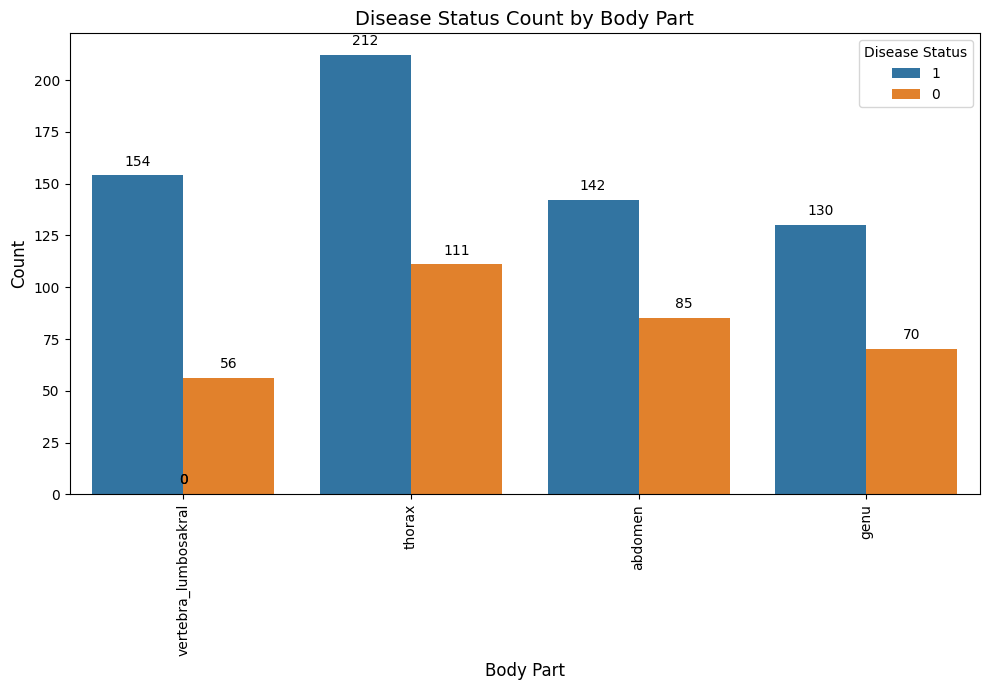

In [28]:
plot_df = df_train_val.copy()
plot_df['body_part'] = plot_df['body_part'].astype(str)
plot_df['disease_status'] = plot_df['disease_status'].astype(str)

plt.figure(figsize=(10, 7))  # Increase the figure size for better readability
ax = sns.countplot(x='body_part', hue='disease_status', data=plot_df)
plt.xlabel('Body Part', fontsize=12)  # You can adjust the font size as needed
plt.ylabel('Count', fontsize=12)  # You can adjust the font size as needed
plt.title('Disease Status Count by Body Part', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Add count annotations to each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.legend(title='Disease Status')
plt.tight_layout()
plt.show()

In [29]:
def find_duplicates(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    duplicates = set1.intersection(set2)
    return list(duplicates)

In [30]:
from tensorflow.keras.utils import Sequence
import math

class PairedImageGenerator(Sequence):
    def __init__(self, image_pairs, labels, batch_size, augmenter, shuffle=False):
        self.image_pairs = image_pairs
        self.labels = labels
        self.batch_size = batch_size
        self.augmenter = augmenter
        self.shuffle = shuffle
        self.on_epoch_end()  # Shuffle data initially if needed

    def __len__(self):
        return math.ceil(len(self.image_pairs) / self.batch_size)

    def on_epoch_end(self):
        # Only shuffle if self.shuffle is set to True
        if self.shuffle:
            self.image_pairs, self.labels = self._shuffle_pairs_and_labels(self.image_pairs, self.labels)

    def __getitem__(self, idx):
        batch_pairs = self.image_pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x1 = []
        batch_x2 = []
        for img1, img2 in batch_pairs:
            batch_x1.append(self.augmenter.random_transform(img1))
            batch_x2.append(self.augmenter.random_transform(img2))

        return [np.array(batch_x1), np.array(batch_x2)], np.array(batch_y)
        
    @staticmethod
    def _shuffle_pairs_and_labels(image_pairs, labels):
        # Combine the list of image pairs and the labels into a single list
        combined = list(zip(image_pairs, labels))
        # Shuffle the combined list
        np.random.shuffle(combined)
        # Separate the shuffled image pairs and labels
        shuffled_pairs, shuffled_labels = zip(*combined)
        return list(shuffled_pairs), np.array(shuffled_labels)

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

# Get the total number of samples in the DataFrame
total_samples = len(df_train_val)

# Divide the indices into three equal parts
part_size = total_samples // 3

# Define the indices for each part
part1_indices = np.arange(0, part_size)
part2_indices = np.arange(part_size, 2 * part_size)
part3_indices = np.arange(2 * part_size, total_samples)

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define your ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

fold_no = 1
all_true_labels = []
all_predictions = []
all_train_loss = []
all_train_accuracy = []
all_val_loss = []
all_val_accuracy = []
for train, test in skf.split(df_train_val[['img_1', 'img_2']], df_train_val['disease_status']):
    print(f"Training on fold {fold_no}...")
    # Split the data
    if fold_no == 1:
        train_indices = np.concatenate((part1_indices, part2_indices))
        test_indices = part3_indices
    elif fold_no == 2:
        train_indices = np.concatenate((part2_indices, part3_indices))
        test_indices = part1_indices
    else:
        train_indices = np.concatenate((part1_indices, part3_indices))
        test_indices = part2_indices
    
    train_df = df_train_val.iloc[train_indices]
    test_df = df_train_val.iloc[test_indices]
    
    df_majority = train_df[(train_df['disease_status'] == 1)]
    df_minority = train_df[(train_df['disease_status'] == 0)]
    
    df_minority_oversampled = resample(df_minority, 
                                       replace=True,     # Sample with replacement
                                       n_samples=len(df_minority) + 300,    # Match number in majority class
                                       random_state=123) # Reproducible results
    
    df_majority_oversampled = resample(df_majority, 
                                       replace=True,     # Sample with replacement
                                       n_samples=len(df_majority) + 200,    # Match number in majority class
                                       random_state=123) # Reproducible results
    
    train_df = pd.concat([df_majority_oversampled, df_minority_oversampled, train_df])

    # Select one-third of the remaining training data for the validation set
    train_df, val_df = train_test_split(train_df, test_size=1/3, random_state=42)

    test_df['concatenated_paths'] = test_df['img_1'] + test_df['img_2']
    concatenated_paths_test_list = test_df['concatenated_paths'].tolist()
    
    train_df['concatenated_paths'] = train_df['img_1'] + train_df['img_2']
    concatenated_paths_train_list = train_df['concatenated_paths'].tolist()
    
    val_df['concatenated_paths'] = val_df['img_1'] + val_df['img_2']
    concatenated_paths_val_list = val_df['concatenated_paths'].tolist()

    print(find_duplicates(concatenated_paths_train_list, concatenated_paths_test_list))
    print(find_duplicates(concatenated_paths_val_list, concatenated_paths_test_list))
        
    # Preprocess the data
    X_train, y_train = preprocess_data(train_df)
    X_val, y_val = preprocess_data(val_df)
    X_test, y_test = preprocess_data(test_df)

    train_dataset = PairedImageGenerator(X_train, y_train, BATCH_SIZE, datagen, shuffle=True)
    val_dataset = PairedImageGenerator(X_val, y_val, BATCH_SIZE, ImageDataGenerator())  # No augmentation

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: weight for i, weight in zip(np.unique(y_train), class_weights)}
    
    # Define your learning rate
    learning_rate = 0.001  # Example learning rate value
    
    # Initialize the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Define EarlyStopping
    # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Change to 'val_accuracy' or another metric if monitoring accuracy
        patience=10,  # Adjust based on how many epochs you're willing to wait without improvement
        mode='min',  # 'min' for loss, 'max' for accuracy
        verbose=1,  # Print log messages when stopping
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
    )
    # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Fit the model
    history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=val_dataset,
        class_weight=class_weights_dict,
        callbacks=[early_stop]
    )

    all_train_loss.append(history.history['loss'])
    all_train_accuracy.append(history.history['accuracy'])
    all_val_loss.append(history.history['val_loss'])
    all_val_accuracy.append(history.history['val_accuracy'])
    
    # Now you have validation results, and you can use them to analyze the performance.
    val_predictions = model.predict(val_dataset)
    val_predicted_labels = (val_predictions > 0.5).astype(int).flatten()
    val_true_labels = y_val

    print(f'Fold {fold_no}: Performance on Validation Data')
    # Calculate the accuracy score
    val_accuracy = accuracy_score(val_true_labels, val_predicted_labels)
    print(f'Val accuracy: {val_accuracy:.2f}')
    
    sensitivity = recall_score(val_true_labels, val_predicted_labels)
    print(f'Val Sensitivity: {sensitivity:.2f}')
    
    # Calculate the ROC-AUC score
    val_auc = roc_auc_score(val_true_labels, val_predictions)
    print(f'Val ROC-AUC: {val_auc:.2f}')
    
    val_f1_score = f1_score(val_true_labels, val_predicted_labels, average='weighted')
    print(f'Val F1 score (weighted average): {val_f1_score:.2f}')

    test_dataset = PairedImageGenerator(X_test, y_test, BATCH_SIZE, ImageDataGenerator()) # no augmentation

    # Make predictions on the test dataset
    predictions = model.predict(test_dataset)
    
    # Convert the predicted probabilities to binary class labels
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    
    true_labels = y_test  

    all_true_labels.append(true_labels)
    all_predictions.append(predictions)
    
    # Calculate the accuracy score
    print(f'Fold {fold_no}: Performance on Test Data')
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Test accuracy: {accuracy:.2f}')
    
    sensitivity = recall_score(true_labels, predicted_labels)
    print(f'Test sensitivity: {sensitivity:.2f}')
    
    # Calculate the ROC-AUC score
    auc = roc_auc_score(true_labels, predictions)
    print(f'Test ROC-AUC: {auc:.2f}')

    test_f1_score = f1_score(true_labels, predicted_labels, average='weighted')
    print(f'Test F1 score (weighted average): {test_f1_score:.2f}')

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    print("Test Confusion Matrix:")
    print(conf_matrix)

    fold_no += 1

Training on fold 1...
[]
[]


/tmp/ipykernel_480081/1385312654.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['concatenated_paths'] = test_df['img_1'] + test_df['img_2']


Epoch 1/50
10/10 [==============================] - 25s 2s/step - loss: 0.6911 - accuracy: 0.5388 - val_loss: 0.6748 - val_accuracy: 0.6700
Epoch 2/50
10/10 [==============================] - 22s 2s/step - loss: 0.6723 - accuracy: 0.5700 - val_loss: 0.6561 - val_accuracy: 0.6667
Epoch 3/50
10/10 [==============================] - 23s 2s/step - loss: 0.6644 - accuracy: 0.5978 - val_loss: 0.6642 - val_accuracy: 0.6027
Epoch 4/50
10/10 [==============================] - 23s 2s/step - loss: 0.6333 - accuracy: 0.6164 - val_loss: 0.6437 - val_accuracy: 0.6414
Epoch 5/50
10/10 [==============================] - 23s 2s/step - loss: 0.5996 - accuracy: 0.6543 - val_loss: 0.6261 - val_accuracy: 0.6498
Epoch 6/50
10/10 [==============================] - 23s 2s/step - loss: 0.5888 - accuracy: 0.6585 - val_loss: 0.6413 - val_accuracy: 0.6094
Epoch 7/50
10/10 [==============================] - 23s 2s/step - loss: 0.5680 - accuracy: 0.6914 - val_loss: 0.5720 - val_accuracy: 0.6987
Epoch 8/50
10/10 [==

/tmp/ipykernel_480081/1385312654.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['concatenated_paths'] = test_df['img_1'] + test_df['img_2']


Epoch 1/50
10/10 [==============================] - 25s 2s/step - loss: 0.6363 - accuracy: 0.7285 - val_loss: 0.4401 - val_accuracy: 0.7778
Epoch 2/50
10/10 [==============================] - 22s 2s/step - loss: 0.5085 - accuracy: 0.7378 - val_loss: 0.5961 - val_accuracy: 0.5993
Epoch 3/50
10/10 [==============================] - 22s 2s/step - loss: 0.4193 - accuracy: 0.7766 - val_loss: 0.4120 - val_accuracy: 0.8013
Epoch 4/50
10/10 [==============================] - 23s 2s/step - loss: 0.3810 - accuracy: 0.8145 - val_loss: 0.4472 - val_accuracy: 0.7997
Epoch 5/50
10/10 [==============================] - 22s 2s/step - loss: 0.3543 - accuracy: 0.8246 - val_loss: 0.3736 - val_accuracy: 0.8333
Epoch 6/50
10/10 [==============================] - 22s 2s/step - loss: 0.3350 - accuracy: 0.8440 - val_loss: 0.3751 - val_accuracy: 0.8300
Epoch 7/50
10/10 [==============================] - 22s 2s/step - loss: 0.2931 - accuracy: 0.8659 - val_loss: 0.4401 - val_accuracy: 0.8064
Epoch 8/50
10/10 [==

/tmp/ipykernel_480081/1385312654.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['concatenated_paths'] = test_df['img_1'] + test_df['img_2']


Epoch 1/50
10/10 [==============================] - 25s 2s/step - loss: 0.2296 - accuracy: 0.9073 - val_loss: 0.4079 - val_accuracy: 0.8266
Epoch 2/50
10/10 [==============================] - 22s 2s/step - loss: 0.1861 - accuracy: 0.9165 - val_loss: 0.2961 - val_accuracy: 0.8788
Epoch 3/50
10/10 [==============================] - 23s 2s/step - loss: 0.1379 - accuracy: 0.9410 - val_loss: 0.4048 - val_accuracy: 0.8434
Epoch 4/50
10/10 [==============================] - 22s 2s/step - loss: 0.1221 - accuracy: 0.9528 - val_loss: 0.4839 - val_accuracy: 0.8401
Epoch 5/50
10/10 [==============================] - 22s 2s/step - loss: 0.1391 - accuracy: 0.9427 - val_loss: 0.7993 - val_accuracy: 0.7492
Epoch 6/50
10/10 [==============================] - 22s 2s/step - loss: 0.1798 - accuracy: 0.9266 - val_loss: 0.5232 - val_accuracy: 0.8215
Epoch 7/50
10/10 [==============================] - 22s 2s/step - loss: 0.1593 - accuracy: 0.9309 - val_loss: 0.3740 - val_accuracy: 0.8636
Epoch 8/50
10/10 [==

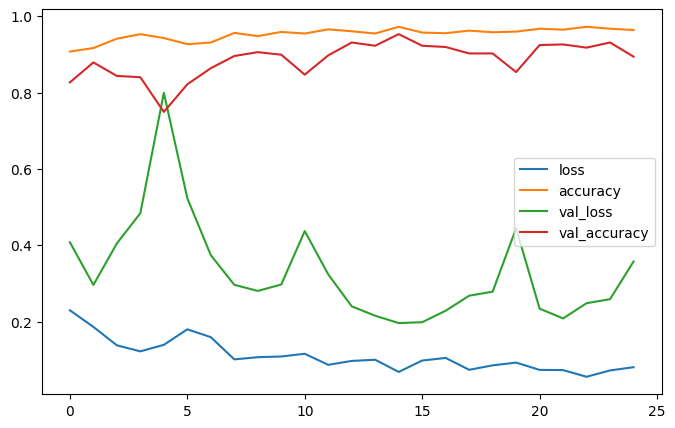

In [32]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

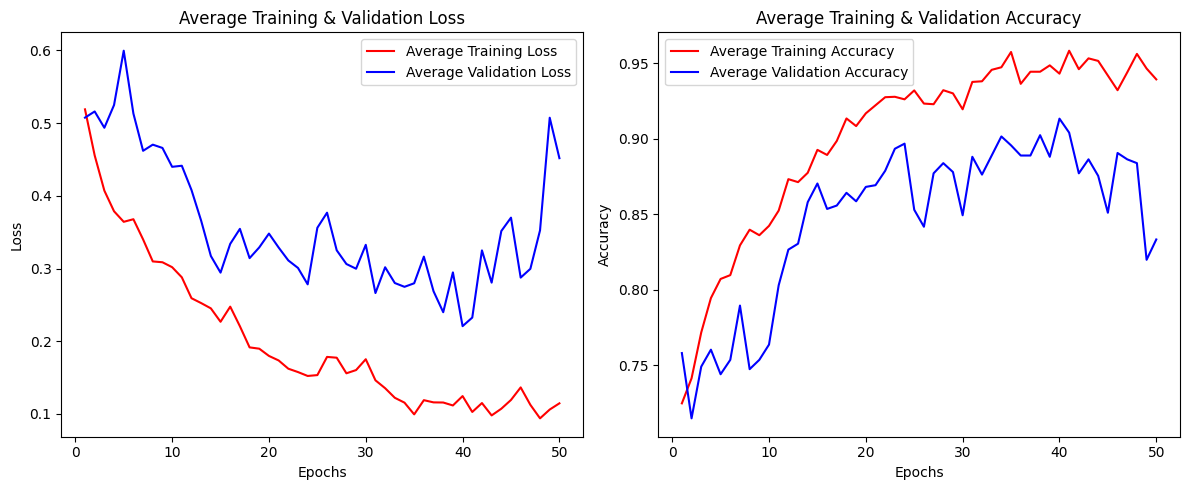

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the average of the collected metrics
def average_across_folds(metric_list):
    # Find the longest list
    max_length = max(len(metrics) for metrics in metric_list)
    # Extend all lists to max_length
    extended_metrics = [np.pad(metrics, (0, max_length - len(metrics)), 'constant', constant_values=np.nan) for metrics in metric_list]
    # Calculate the mean while ignoring NaNs
    mean_metrics = np.nanmean(np.array(extended_metrics), axis=0)
    return mean_metrics

# Plotting
epochs = range(1, len(average_across_folds(all_train_loss)) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, average_across_folds(all_train_loss), 'r-', label='Average Training Loss')
plt.plot(epochs, average_across_folds(all_val_loss), 'b-', label='Average Validation Loss')
plt.title('Average Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, average_across_folds(all_train_accuracy), 'r-', label='Average Training Accuracy')
plt.plot(epochs, average_across_folds(all_val_accuracy), 'b-', label='Average Validation Accuracy')
plt.title('Average Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

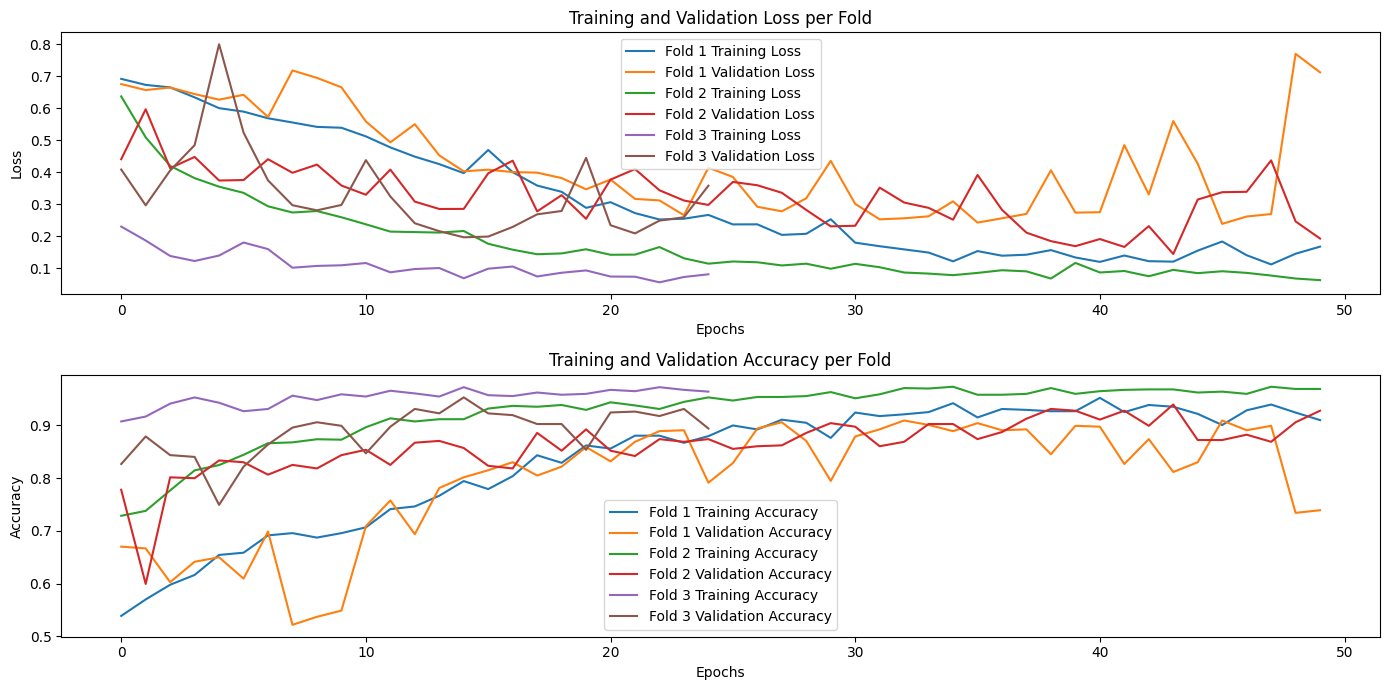

In [34]:
# Plot each fold's metrics
plt.figure(figsize=(14, 7))

for i in range(len(all_train_loss)):
    plt.subplot(2, 1, 1)
    plt.plot(all_train_loss[i], label=f'Fold {i+1} Training Loss')
    plt.plot(all_val_loss[i], label=f'Fold {i+1} Validation Loss')
    plt.title('Training and Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(all_train_accuracy[i], label=f'Fold {i+1} Training Accuracy')
    plt.plot(all_val_accuracy[i], label=f'Fold {i+1} Validation Accuracy')
    plt.title('Training and Validation Accuracy per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

all_true_labels = np.concatenate(all_true_labels)
all_predictions = np.concatenate(all_predictions)

# # Now you can calculate the ROC curve and AUC for all folds combined
# fpr, tpr, _ = roc_curve(all_true_labels, all_predictions)
# roc_auc = auc(fpr, tpr)

# # And plot the combined ROC curve
# plt.figure()
# plt.plot(fpr, tpr, label=f'Combined ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Combined Test ROC Curve for All Folds')
# plt.legend(loc='lower right')
# plt.show()

In [36]:
model.save('mobilenet_combination_model_fold_4bp_4.h5')

/home/radiology/miniconda3/envs/tf-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score

overall_predicted_labels = (all_predictions > 0.5).astype(int)
# Calculate the accuracy score
overall_accuracy = accuracy_score(all_true_labels, overall_predicted_labels)
overall_sensitivity = recall_score(all_true_labels, overall_predicted_labels)
overall_auc = roc_auc_score(all_true_labels, all_predictions)

print(f'Overall Test accuracy: {overall_accuracy:.2f}')
print(f'Overall Test sensitivity: {overall_sensitivity:.2f}')
print(f'Overall Test ROC-AUC: {overall_auc:.2f}')

Overall Test accuracy: 0.79
Overall Test sensitivity: 0.74
Overall Test ROC-AUC: 0.90


In [38]:
from sklearn.metrics import f1_score, classification_report

report = classification_report(all_true_labels, overall_predicted_labels)
print("Classification Report:\n", report)

f1 = f1_score(all_true_labels, overall_predicted_labels)
print(f'Test F1 score: {f1:.2f}')

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.90      0.75       322
           1       0.94      0.74      0.83       638

    accuracy                           0.79       960
   macro avg       0.79      0.82      0.79       960
weighted avg       0.84      0.79      0.80       960

Test F1 score: 0.83


[[291  31]
 [168 470]]


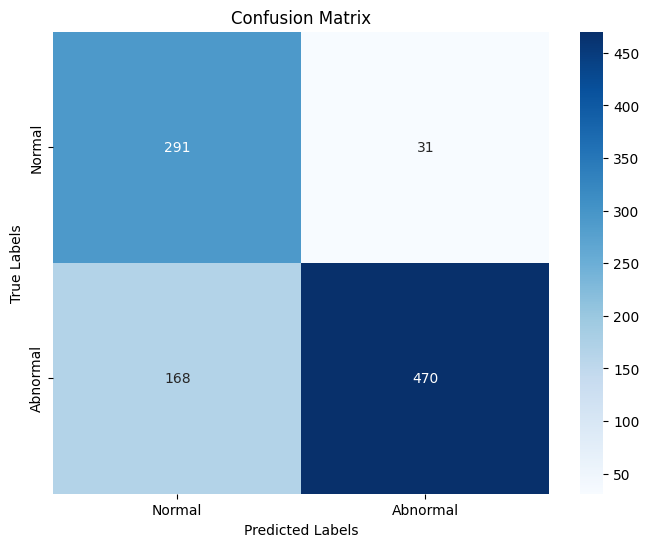

In [39]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for binary classification
conf_matrix = confusion_matrix(all_true_labels, overall_predicted_labels)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [40]:
df_test.to_csv('df_test_4bp_mobilenet_4.csv', index=False) 

In [41]:
from sklearn.metrics import f1_score, classification_report

# Test accuracy
X_test, y_test = preprocess_data(df_test)

test_dataset = PairedImageGenerator(X_test, y_test, BATCH_SIZE, ImageDataGenerator()) # no augmentation

# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Convert the predicted probabilities to binary class labels
predicted_labels = (predictions > 0.5).astype(int).flatten()

true_labels = y_test  

# Calculate the accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Test accuracy: {accuracy:.2f}')

sensitivity = recall_score(true_labels, predicted_labels)
print(f'Test sensitivity: {sensitivity:.2f}')

# Calculate the ROC-AUC score
auc = roc_auc_score(true_labels, predictions)
print(f'Test ROC-AUC: {auc:.2f}')

report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", report)

f1 = f1_score(true_labels, predicted_labels)
print(f'Test F1 score: {f1:.2f}')

2/2 [==============================] - 3s 1s/step
Test accuracy: 0.78
Test sensitivity: 0.85
Test ROC-AUC: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.62      0.65        80
           1       0.82      0.85      0.83       160

    accuracy                           0.78       240
   macro avg       0.75      0.74      0.74       240
weighted avg       0.77      0.78      0.77       240

Test F1 score: 0.83


[[ 50  30]
 [ 24 136]]


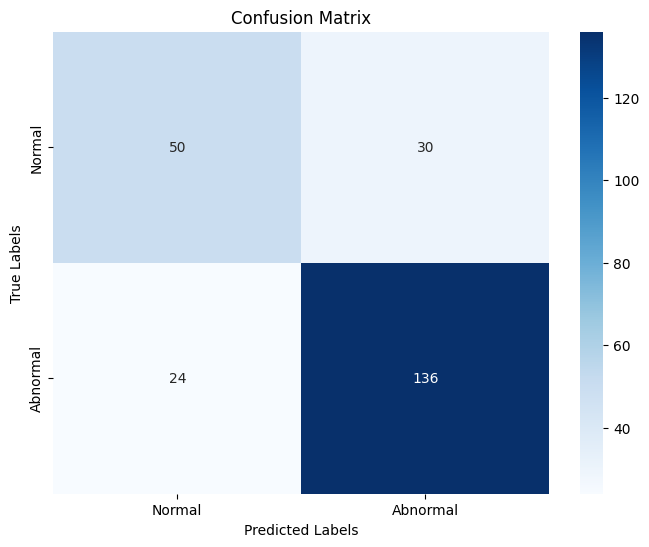

In [42]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix for binary classification
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [43]:
import numpy as np

def predict_per_patient(patient_ids, predictions):
    patient_predictions = {}
    for patient_id, prediction in zip(patient_ids, predictions):
        # if patient_id isn't already a key, create it as a key with empty list as the initial value
        if patient_id not in patient_predictions:
            patient_predictions[patient_id] = []
        # append each prediction associated to the patient_id
        patient_predictions[patient_id].append(prediction)

    # get maximum prediction value
    patient_results = {pid: np.max(preds) for pid, preds in patient_predictions.items()} 
    return patient_results

# get a list of patient id from the test data
patient_ids_test = df_test['patient_id'].tolist() 

patient_prediction = model.predict(test_dataset)
patient_predicted_labels = (patient_prediction > 0.5).astype(int).flatten()

# Now we call the new function to get a prediction per patient
patient_results = predict_per_patient(patient_ids_test, patient_predicted_labels)

2/2 [==============================] - 3s 1s/step


In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Ground truth labels for each patient, you might need to adjust how you retrieve these
# This should be a dictionary or a list that contains the true disease status per patient
true_labels_by_patient = {patient_id: true_label for patient_id, true_label in zip(df_test['patient_id'], df_test['disease_status'])}
print(true_labels_by_patient)

# Convert predicted patient results and true labels to lists, maintaining the same order
predicted_labels_list = [patient_results[pid] for pid in patient_ids_test]
true_labels_list = [true_labels_by_patient[pid] for pid in patient_ids_test]

# Calculate accuracy
accuracy = accuracy_score(true_labels_list, predicted_labels_list)
print(f'Accuracy: {accuracy:.2f}')

sensitivity = recall_score(true_labels_list, predicted_labels_list)
print(f'Sensitivity: {sensitivity:.2f}')

# Calculate ROC-AUC score
# Note: ROC-AUC can only be calculated with probability scores, not binary predictions.
# If your `patient_results` are binary, you should instead aggregate raw probability scores
# For example purposes, assuming patient_prediction is raw probabilities, here is how it might look
true_labels_prob = [np.max(patient_prediction[np.where(np.array(patient_ids_test) == pid)]) for pid in patient_ids_test]
roc_auc = roc_auc_score(true_labels_list, true_labels_prob)
print(f'ROC-AUC: {roc_auc:.2f}')

{49: 0, 271: 1, 416: 0, 11: 0, 458: 0, 35: 1, 655: 0, 66: 1, 388: 1, 526: 0, 51: 1, 625: 0, 200: 1, 501: 1, 234: 0, 631: 1, 263: 1, 227: 0, 468: 0, 359: 0, 855: 1, 857: 0, 578: 0, 306: 1, 48: 1, 47: 0, 65: 1, 116: 1, 288: 0, 428: 0, 575: 0, 28: 1, 476: 1, 143: 1, 678: 1, 709: 1, 673: 1, 184: 0, 815: 1, 705: 0, 55: 1, 859: 1, 713: 1, 14: 0, 636: 1, 289: 1, 58: 1, 86: 1, 825: 1, 717: 0, 258: 0, 44: 0, 15: 1, 72: 1, 41: 1, 489: 1, 196: 1, 89: 1, 38: 1, 875: 1, 152: 1, 119: 1, 461: 1, 613: 1, 666: 1, 594: 0, 22: 1, 146: 1, 283: 1, 845: 1, 736: 1, 404: 0, 672: 1, 256: 0, 163: 1, 45: 1, 375: 1, 739: 0, 108: 1, 67: 1, 479: 0, 828: 0, 57: 0, 771: 1, 231: 0, 463: 1, 707: 1, 453: 1, 363: 1, 669: 1, 420: 1, 732: 1, 115: 1, 194: 0, 659: 1, 589: 1, 432: 1, 75: 0, 787: 1, 165: 1, 32: 1, 580: 1, 204: 1, 1: 0, 259: 0, 574: 1, 703: 1, 601: 0, 94: 0, 606: 0, 73: 0, 192: 1, 430: 1, 402: 1, 760: 1, 668: 1, 219: 1, 492: 0, 336: 1, 610: 0, 83: 1, 809: 1, 854: 1, 394: 1, 296: 1, 24: 1, 876: 1, 455: 0, 260: 0

In [45]:
report2 = classification_report(true_labels_list, predicted_labels_list)
print("Classification Report:\n", report2)

f1 = f1_score(true_labels_list, predicted_labels_list)
print(f'F1 Score: {f1:.2f}')

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.60      0.64        80
           1       0.81      0.86      0.83       160

    accuracy                           0.77       240
   macro avg       0.74      0.73      0.73       240
weighted avg       0.77      0.77      0.77       240

F1 Score: 0.83


[[ 48  32]
 [ 23 137]]


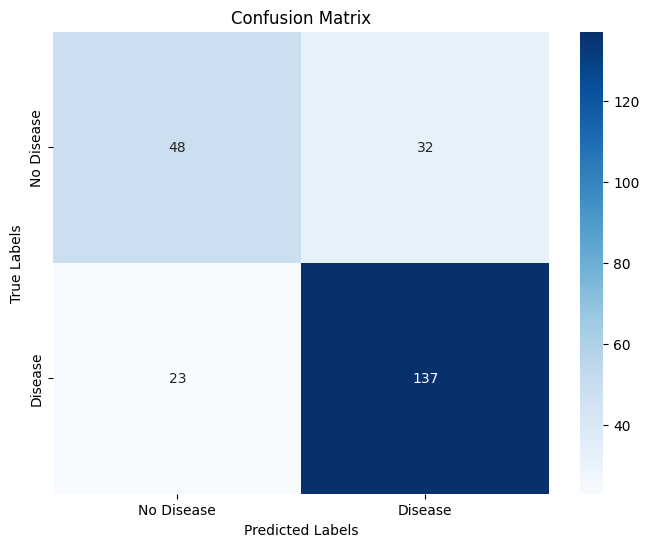

In [46]:
conf_matrix2 = confusion_matrix(true_labels_list, predicted_labels_list)
print(conf_matrix2)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [47]:
import random
def predict_binary(test_dataset, model):
    # Convert the test dataset to a list of batches
    batches = list(test_dataset.unbatch().batch(1).as_numpy_iterator())

    # randomly select a batch (one pair of images and its label)
    random_index = random.randint(0, len(batches) - 1)
    (img1, img2), true_binary_label = batches[random_index]
    
    # make a prediction using the selected pair of images
    img1_batch = np.expand_dims(img1[0], axis=0)
    img2_batch = np.expand_dims(img2[0], axis=0)
    prediction = model.predict([img1_batch, img2_batch])
    
    # Extract the binary prediction (assuming it's the first array in the list)
    predicted_binary_label = (prediction > 0.5).astype(int).flatten()[0]

    print(f"Predicted binary label: {predicted_binary_label}, True binary label: {true_binary_label}")

In [48]:
predict_binary(test_dataset, model)

AttributeError: 'PairedImageGenerator' object has no attribute 'unbatch'

In [ ]:
# Access the first batch of data and labels
batch_data, batch_labels = val_dataset[1]

# Unpack the batch_data into separate arrays for image pairs
batch_x1, batch_x2 = batch_data

# Now you can access the image pairs from batch_x1 and batch_x2
# Display the first image in the pair (batch_x1)
plt.imshow(batch_x1[10], cmap='gray')
plt.title('Image 1')
plt.axis('off')
plt.show()

print('valdf')
print('length val', len(val_df))
print(val_df.groupby('body_part').size())
print('testdf')
print(df_test.groupby('body_part').size())
print('length test', len(df_test))
print('traindf')
print(df_train.groupby('body_part').size())
print('length train', len(df_train))

print(val_df.head())
df_test['concatenated_paths'] = df_test['img_1'] + df_test['img_2']
concatenated_paths_test_list = df_test['concatenated_paths'].tolist()

df_train['concatenated_paths'] = df_train['img_1'] + df_train['img_2']
concatenated_paths_train_list = df_train['concatenated_paths'].tolist()

val_df['concatenated_paths'] = val_df['img_1'] + val_df['img_2']
concatenated_paths_val_list = val_df['concatenated_paths'].tolist()

def find_duplicates(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    duplicates = set1.intersection(set2)
    return list(duplicates)

print(concatenated_paths_test_list)
find_duplicates(concatenated_paths_train_list, concatenated_paths_val_list)

In [ ]:
false_positive_indices = np.where((true_labels == 0) & (predicted_labels == 1))[0]
false_negative_indices = np.where((true_labels == 1) & (predicted_labels == 0))[0]

X_test_paths = df_test['body_part'].tolist()

# Print image paths for true negatives and false negatives
print("False Positive Indices  Image Paths:")
for i in false_positive_indices :
    print(X_test_paths [i])

print('\n', "False Negative Image Paths:")
for i in false_negative_indices:
    print(X_test_paths [i])